## GPU Accelerated Interpretable Machine Learning for Diversified Portfolio Construction

In this notebook, we accelerated a pipeline to benchmark Hierarchical Risk Parity (HRP) relative to Naive Risk Parity (NRP) in the GPU as described in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3730144). It is an example of diversification strategy allocating to liquid multi-asset futures markets with dynamic leverage ("volatility target"). This workflow includes following steps:

* Load csv data of asset daily prices
* Run block bootstrap to generate 100k different scenarios.
* Compute the log returns for each scenario. 
* Compute assets distances to run hierarchical clustering and Hierarchical Risk Parity (HRP) weights for the assets
* Compute the weights for the assets based on the Naïve Risk Parity (NRP) method.
* Compute the transaction cost based on weights adjustment on the rebalancing days
* At every rebalancing date, calculate the portfolio leverage to reach the volatility target.
* Compute the Average annual Returns, Std Returns, Sharpe Ratios, Maximum Drawdown, and Calmar Ratio performance metrics for these two methods (HRP-NRP)

## Background

**Naive Risk Parity**  Naive Risk Parity (NRP), is here called naive because it ignores the correlation among the assets. In an RP portfolio, an asset weight is indirectly proportional to its historical volatility as explained in Roncalli (2013). More formally, the weight $w_i$ for the i-thasset with i spanning the portfolio universe $i =1,...,N$ is
$$ w_i = \frac{\sigma_i^{-1}}{\sum_{j}\sigma_j^{-1}}$$
where $\sigma_i = \sqrt{\sum_{ii}}$ denotes the volatility of asset i.

**HRP** The standard HRP approach (Lopez de Prado (2016a)) uses a tree clustering algorithm to perform a quasi-diagonalization of the covariance matrix. After the quasi-diagonalization is carried out, a recursive bi-sectioning method is used to define the weights of each asset within the portfolio. The following dendogram shows the top 13 companies by global market cap clustered by the tree clustering algorithm. Notice how financial stocks such as Bank of America and JPMorgan are clustered together. Same happens for Asian stocks (Tencent and Alibaba) or IT giants (Google, Amazon, Facebook). 

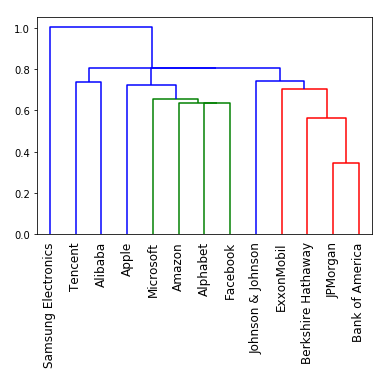

**Performance metrics**

Statistics | Short | Description
--- | --- | ----
Volatility | SD | Annualized volatility
Returns | RET | Annualized returns
Maximum Drawdown | MDD | Drawdowns percentage
Sharpe ratio | SR | The ratio between returns and volatility (annualized)
Calmar Ratio | Calmar | The ratiobetweenannualizedreturns and max drawdown


**Backtests**
The strategies are rebalanced every month. At every rebalancing date, the portfolio leverage is set to reach the volatility target of $\sigma_{target} = 5\%$ annualized in a hindsight. The portfolio leverage
determines the total market value of the portfolio and thus the position quantities of each instrument. The estimation of realized volatility used for the updated leverage number is the
maximum of the volatilities of the portfolio measured over 20 and 60 trading days, respectively $\sigma_{t=20}$ and $\sigma_{t=60}$.  The target weight is calculated as
$$W_{target} = \frac{\sigma_{target}} {\max(\sigma_{t=20}, \sigma_{t=60})}$$

Start the Dask cluster for distributed computation

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:36977 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 251.82 GiB


## Results for the empirical dataset 

Following is the workflow from CSV data loading to backtest performance metrics computation. 

In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML
taskGraph=TaskGraph.load_taskgraph('./17assets/workflow_empirical.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

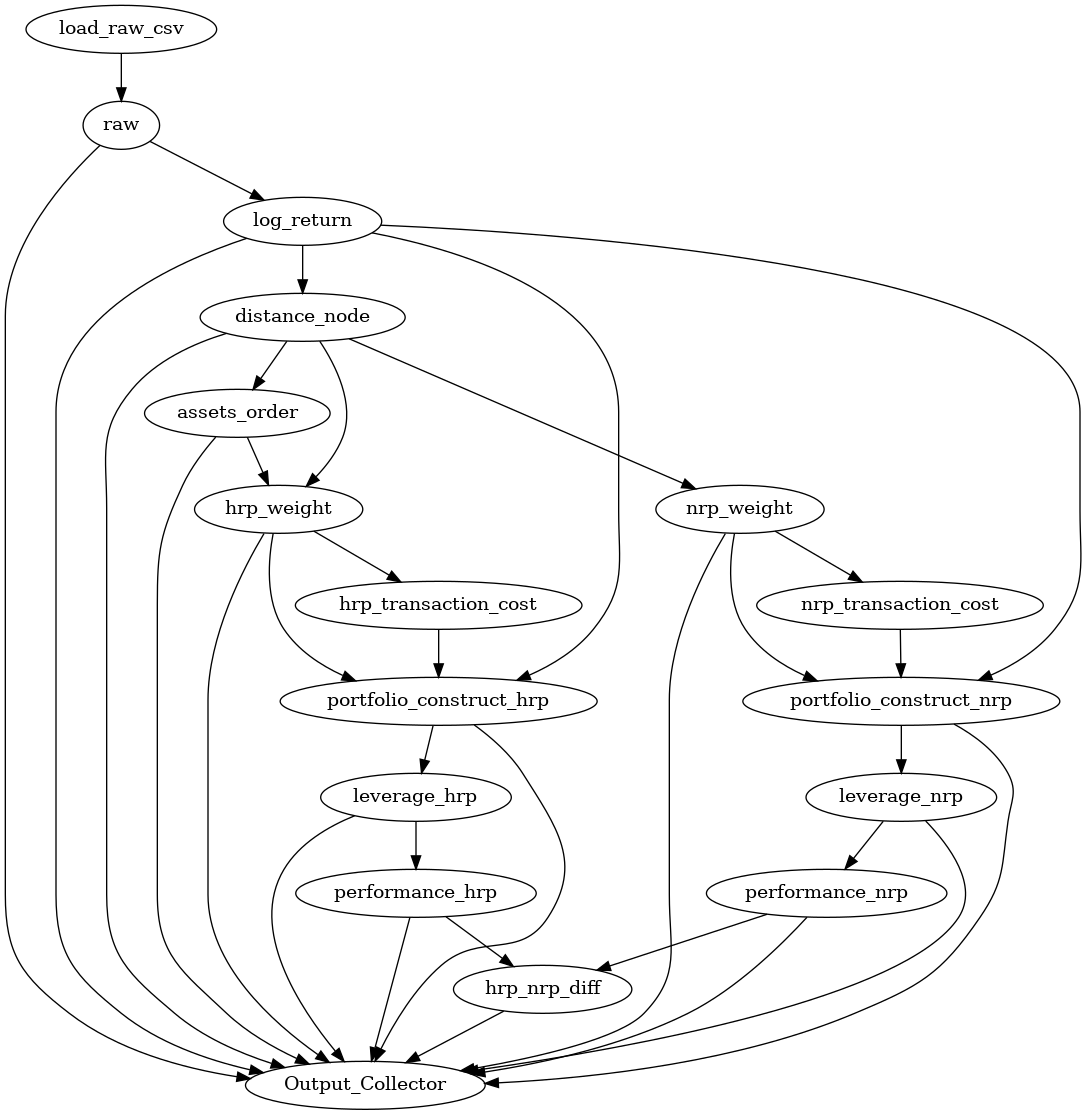

In [3]:
taskGraph.draw(show='ipynb')

We can run the workflow by clicking on the button in the widget or we can run following command. The result will be saved in the `result` variable

In [4]:
result = taskGraph.run()

All the intermediate result can be fetched by the keys of `result` variable. We can list all the keys by running: 

In [5]:
result.get_keys()

('hrp_nrp_diff.out',
 'raw.out',
 'log_return.out',
 'assets_order.out',
 'hrp_weight.out',
 'portfolio_construct_hrp.out',
 'portfolio_construct_nrp.out',
 'nrp_weight.out',
 'distance_node.cov_df',
 'distance_node.distance_df',
 'leverage_hrp.lev_df',
 'leverage_nrp.lev_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.sharpe_df',
 'performance_nrp.sd_df',
 'performance_nrp.ret_df',
 'performance_nrp.maxdd_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df')

Let's plot the empirical dataset strategies performances

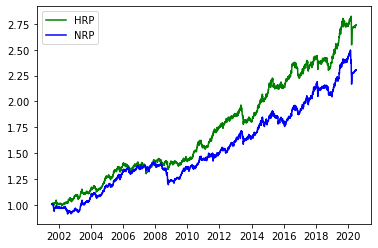

In [6]:
date = result['leverage_nrp.lev_df'].sort_index()['date'].values.get()
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_hrp.lev_df'].sort_index()['portfolio'].values)).get(), color='g', label='HRP')
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_nrp.lev_df'].sort_index()['portfolio'].values)).get(), color='b', label='NRP')
pl.legend()

Organize all the performance metrics in a table

In [7]:
nrp_metrics = [result['performance_nrp.sd_df']['portfolio'].values.item(),
               result['performance_nrp.ret_df']['portfolio'].values.item(),
               result['performance_nrp.maxdd_df']['portfolio'].values.item(),
               result['performance_nrp.calmar_df']['portfolio'].values.item(),
               result['performance_nrp.sharpe_df']['portfolio'].values.item()]
hrp_metrics = [result['performance_hrp.sd_df']['portfolio'].values.item(),
               result['performance_hrp.ret_df']['portfolio'].values.item(),
               result['performance_hrp.maxdd_df']['portfolio'].values.item(),
               result['performance_hrp.calmar_df']['portfolio'].values.item(),
               result['performance_hrp.sharpe_df']['portfolio'].values.item()]
metrics = ['SD', 'RET', 'MDD', 'Calmar', 'SR']
df = cudf.DataFrame({'metrics': metrics, 'NRP': nrp_metrics, 'HRP': hrp_metrics})
df.set_index('metrics')

,NRP,HRP
metrics,,
SD,0.053235,0.051569
RET,0.045118,0.054740
MDD,0.155329,0.098149
Calmar,0.290464,0.557726
SR,0.847511,1.061491


## Robustness of the strategies

Bootstrapped dataset To account for the non-stationarity of futures return time series, we generate an additional dataset of time-series by block bootstrapping (Hall (1985), Carlstein and others(1986), Fengler and Schwendner(2004) and Lohre, Rother, and Schaefer (2020)):

* Blocks with a fixed length, but a random starting point in time are defined from the futures return time-series. One block corresponds to 60 business days. This block length is motivated by a typical monthly or quarterly rebalancing frequency of dynamic rule-based strategies and by the empirical market dynamics that happen on this time scale. Papenbrock and Schwendner (2015) found multi-asset correlation patterns to change at a typical frequency of a few months.
* A new return time-series is constructed by sampling the blocks with replacement to reconstruct a time-series with the same length of the original time-series. 

We added a Bootstrap Node to accelerate the bootstrap computation in the GPU. Run 4096 bootstrap samples, we can build a distribution of the performance metrics. Following is the workflow of running the bootstrap.

In [8]:
taskGraph=TaskGraph.load_taskgraph('./17assets/workflow_bootstrap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

Collect the results and list all the result keys:

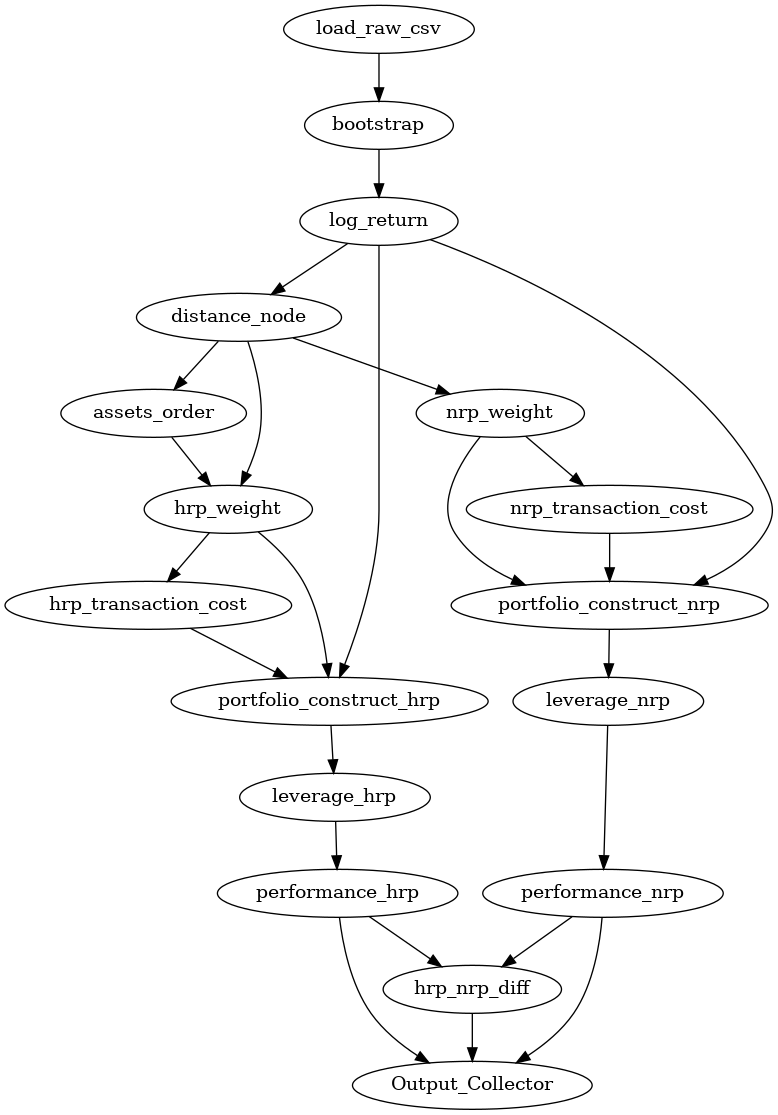

In [9]:
taskGraph.draw(show='ipynb')

In [10]:
result = taskGraph.run()
result.get_keys()

('hrp_nrp_diff.out',
 'performance_nrp.ret_df',
 'performance_nrp.sd_df',
 'performance_nrp.sharpe_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.maxdd_df')

Draw the performance statistics distribution:

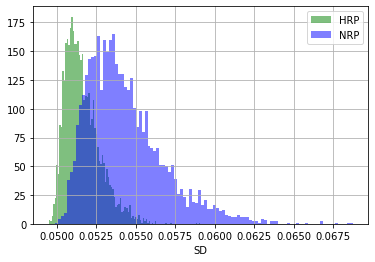

In [11]:
result['performance_hrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SD')
pl.legend()

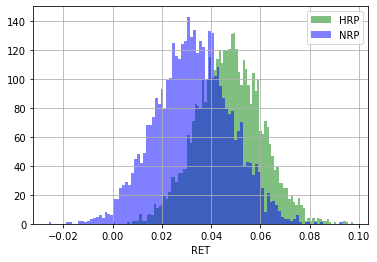

In [12]:
result['performance_hrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('RET')
pl.legend()

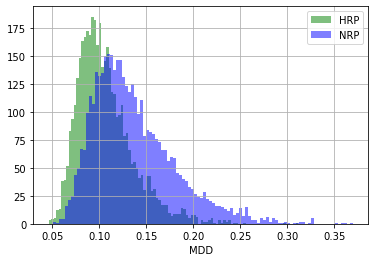

In [13]:
result['performance_hrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('MDD')
pl.legend()

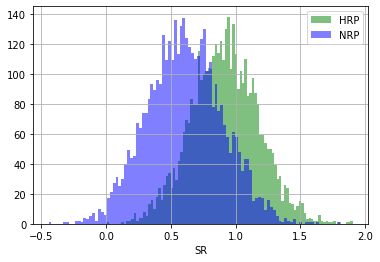

In [14]:
result['performance_hrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SR')
pl.legend()

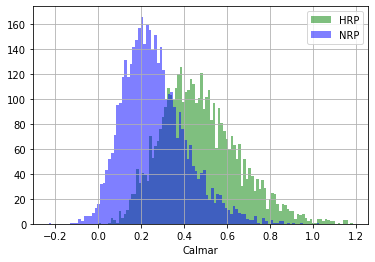

In [15]:
result['performance_hrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('Calmar')
pl.legend()

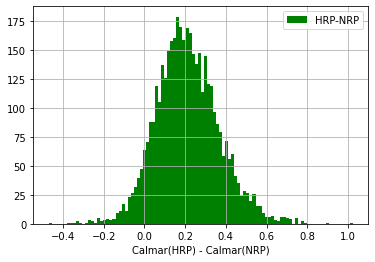

In [16]:
result['hrp_nrp_diff.out'].to_pandas()['portfolio'].hist(bins=100, color='g', label='HRP-NRP')
pl.xlabel('Calmar(HRP) - Calmar(NRP)')
pl.legend()

## Interpretable Machine Learning
In this section, we train a supervised learning model to fit the spread between the Calmar ratios of HRP and the NRP using statistical features of the bootstrapped
datasets. 

**The features**

To characterize the portfolio universe, we select a set of classical statistical features plus a set of quantities that can indicate properties of the hierarchical structure of the asset universe. This particular set of features is tailored to both strategies, and without the help of ML it would be quite difficult to link them to the performances of the strategies. We also look at some features that encode non-stationarity properties. Whenever the feature name has the suffix `_std`., we measure the standard deviation of the statistical property across time. That helps to identify the heterogeneity of that property across the years. 

In total, we use 30 features associated with the portfolio universe. For example, X_mean_mean identifies the mean across assets of the mean returns across time. In other words, it provides information regarding the overall trend of the returns of the full portfolio. The `X_mean_mean_std` instead represents how the overall trend changes across years and is measured by the standard deviation of the `X_mean_means` measured year by year. Another feature is `X_mean_std` that measures the heterogeneity of the returns across the assets. A high value of this quantity means that the overall trend of the returns is characterized by a very heterogeneous behaviour across assets (in general features that have names ending with `X_std` have been measured with the standard deviation of X across assets).  `corr_mean` is the mean of the entries of the correlation matrix (only the lower diagonal terms) and together with `corr_std` (their standard deviation) they provide information on the independence of the asset from the rest of the universe. For example, a negative value of `corr_mean` suggests that there is a high number of assets that are anti-correlated. A value close to zero can represent either a portfolio with independent assets or one with the same degree of positive and negative correlations. In this case, `corr_std` would discriminate between the two possibilities. 

Following is the workflow to calculate all the features for each bootstrap sample in the GPU

In [17]:

taskGraph=TaskGraph.load_taskgraph('./17assets/feature_computation_workflow.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

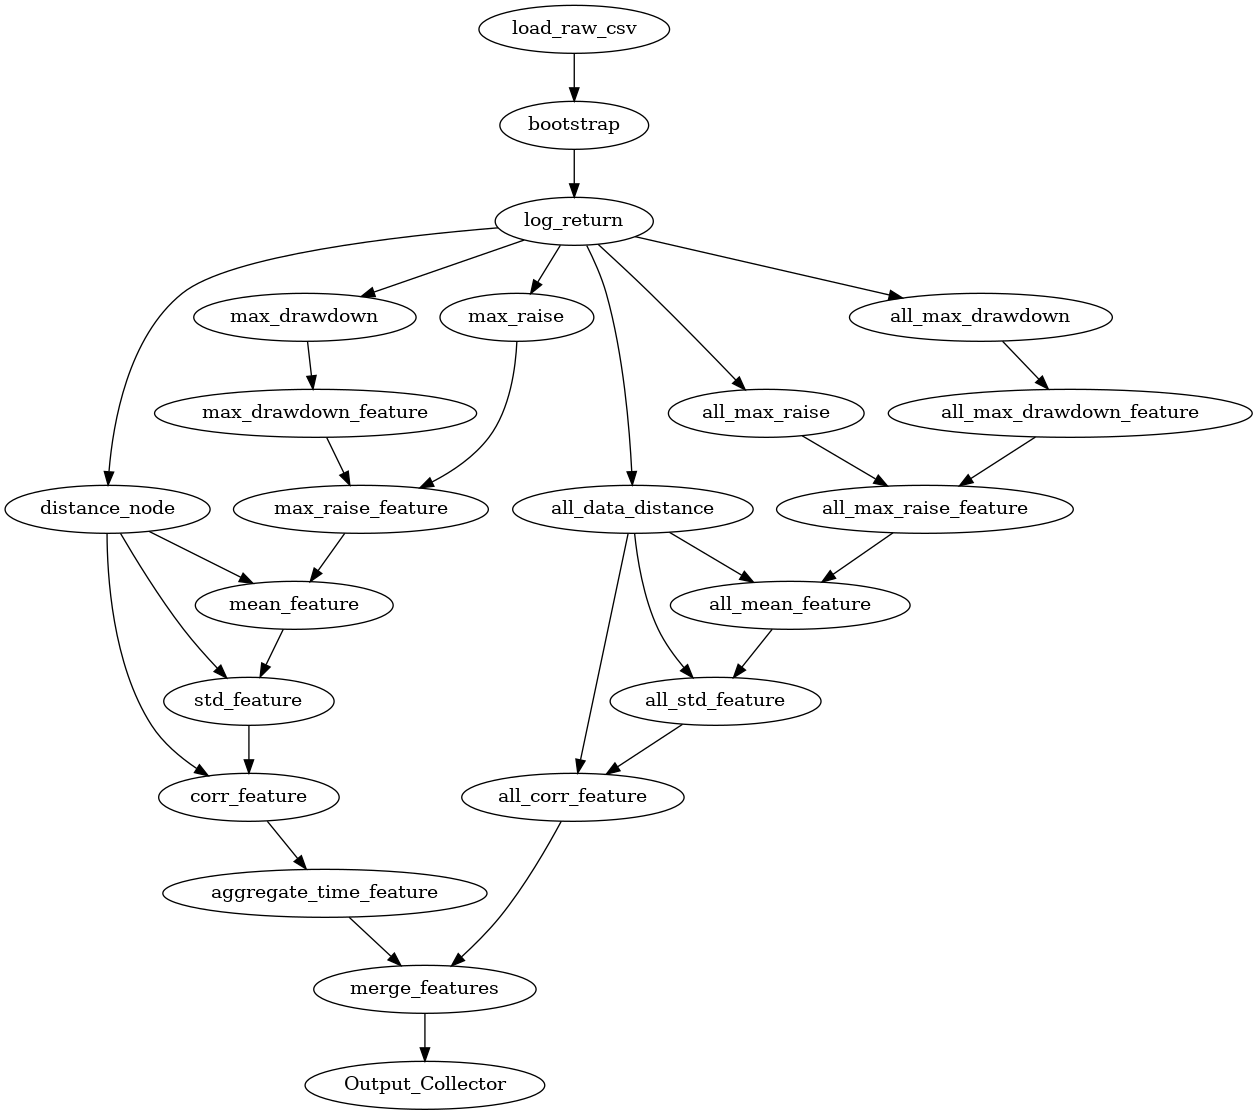

In [18]:
taskGraph.draw(show='ipynb')

In [19]:
del result
result = taskGraph.run()
result['merge_features.merged']

,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,381,0.159579,0.099043,0.188905,0.092726,0.000210,0.000628,0.011127,0.005971,-1.346046,...,0.425666,0.247231,0.752109,0.118822,0.000185,0.000206,0.011538,0.005985,-1.306174,0.703678
1,1163,0.159326,0.102024,0.181239,0.098657,0.000157,0.000606,0.011071,0.006137,-1.344536,...,0.416275,0.202604,0.660051,0.152690,0.000166,0.000085,0.011235,0.006049,-1.325448,0.702820
2,3488,0.179743,0.110795,0.182360,0.098366,0.000019,0.000656,0.011653,0.006706,-1.315738,...,0.521610,0.284115,0.645547,0.127861,0.000037,0.000153,0.011989,0.006833,-1.286280,0.652344
3,1178,0.172724,0.107135,0.177318,0.092856,0.000048,0.000606,0.011968,0.006588,-1.328082,...,0.468940,0.246391,0.597906,0.114046,0.000050,0.000148,0.012548,0.006756,-1.286173,0.673396
4,3271,0.176588,0.111252,0.196184,0.095353,0.000131,0.000649,0.012688,0.006968,-1.353409,...,0.460463,0.247394,0.696122,0.131933,0.000138,0.000186,0.013152,0.006974,-1.326378,0.721126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,1605,0.185526,0.114951,0.172163,0.084098,-0.000075,0.000627,0.011806,0.006509,-1.322735,...,0.574086,0.293252,0.516395,0.092074,-0.000061,0.000220,0.012252,0.006452,-1.281805,0.675732
4092,2583,0.178787,0.111735,0.177982,0.094320,-0.000008,0.000670,0.011796,0.006729,-1.303548,...,0.543506,0.288906,0.564344,0.194227,-0.000003,0.000231,0.012486,0.007019,-1.266224,0.634292
4093,3507,0.153084,0.091166,0.193253,0.103662,0.000277,0.000569,0.010827,0.005726,-1.350270,...,0.388418,0.214661,0.750914,0.204343,0.000286,0.000187,0.011092,0.005610,-1.343296,0.730274
4094,966,0.162761,0.107076,0.178303,0.093909,0.000099,0.000653,0.011129,0.006051,-1.332019,...,0.475684,0.283014,0.677291,0.115946,0.000073,0.000150,0.011463,0.005940,-1.309132,0.696188


The taskgrpah is a bit complicated, we can use `CompositeNode` to group the sub-graph into a single node. Here is a simplified version of it:

In [20]:
taskGraph=TaskGraph.load_taskgraph('./17assets/all_feature_simplified.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

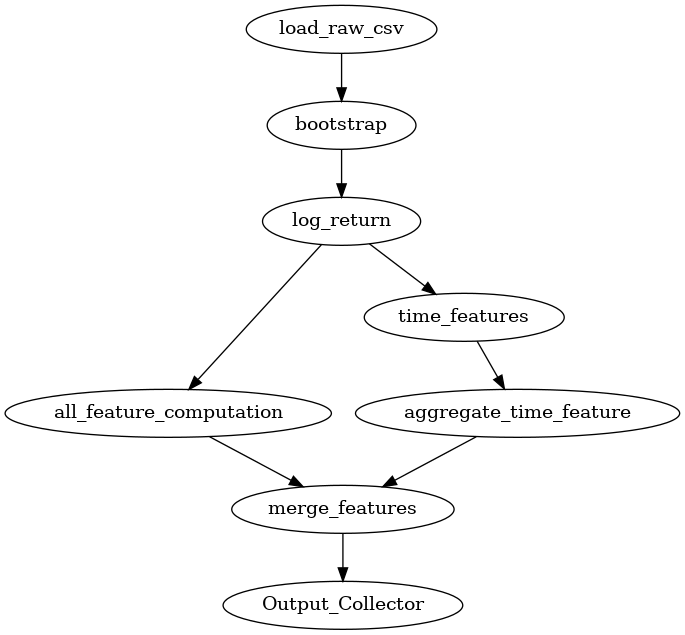

In [21]:
taskGraph.draw(show='ipynb')

In [22]:
del result
result = taskGraph.run()
result['merge_features.merged']

,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,381,0.185382,0.115855,0.174230,0.086180,-0.000077,0.000624,0.012040,0.006615,-1.337834,...,0.571538,0.317369,0.530575,0.129611,-0.000065,0.000212,0.012546,0.006602,-1.297554,0.687568
1,1163,0.146118,0.092658,0.181116,0.094432,0.000217,0.000561,0.010658,0.006000,-1.321000,...,0.395891,0.222011,0.737474,0.135861,0.000181,0.000151,0.011195,0.006138,-1.280588,0.653647
2,3488,0.171263,0.103826,0.184585,0.096704,0.000112,0.000577,0.011481,0.006214,-1.360239,...,0.462610,0.237830,0.682648,0.152001,0.000102,0.000121,0.011774,0.006037,-1.329820,0.712065
3,1178,0.182363,0.114697,0.198104,0.101599,0.000082,0.000707,0.012938,0.007559,-1.352147,...,0.478315,0.239203,0.700172,0.123221,0.000048,0.000195,0.013729,0.007782,-1.315717,0.712943
4,3271,0.174079,0.112008,0.183099,0.100149,0.000065,0.000721,0.011920,0.006850,-1.314167,...,0.476497,0.265360,0.610766,0.179576,0.000073,0.000196,0.012290,0.006762,-1.282794,0.654315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,449,0.174721,0.112379,0.190133,0.095776,0.000087,0.000729,0.012044,0.006773,-1.333648,...,0.490285,0.267167,0.726051,0.152047,0.000070,0.000281,0.012581,0.006830,-1.298220,0.678123
4092,324,0.184589,0.115487,0.193448,0.092443,0.000065,0.000678,0.012610,0.006832,-1.366372,...,0.498827,0.262455,0.721786,0.083005,0.000082,0.000127,0.013179,0.006856,-1.333126,0.750298
4093,545,0.156590,0.097966,0.180100,0.091691,0.000154,0.000603,0.010916,0.005949,-1.362024,...,0.458654,0.261140,0.688310,0.119606,0.000159,0.000147,0.011411,0.006085,-1.338460,0.725637
4094,325,0.153842,0.092626,0.197457,0.103547,0.000295,0.000676,0.010925,0.005935,-1.339364,...,0.456435,0.189639,0.770178,0.207277,0.000273,0.000179,0.011570,0.005995,-1.317206,0.718338


## The ML learning model

For the supervised learning algorithm, we selected XGBoost (Chen and Guestrin (2016)) , a gradient tree boosting library that is fast and accurate as described in the paper. This algorithm can construct non-linear relations among the features. Moreover, for large datasets, it can scale across GPUs to speed-up the learning process. Another benefit of using XGBoost is that it produces fast explanations.

To assess the stability of the explanations, the set of bootstrapped datasets, each across 17 multi-asset futures, is split into 90% training and 10% test set. We trained the model as a regression, to learn the difference between the Calmarratio obtained with HRP minus the Calmar ratio obtained by HRP. 

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [3]:
taskGraph=TaskGraph.load_taskgraph('./17assets/xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

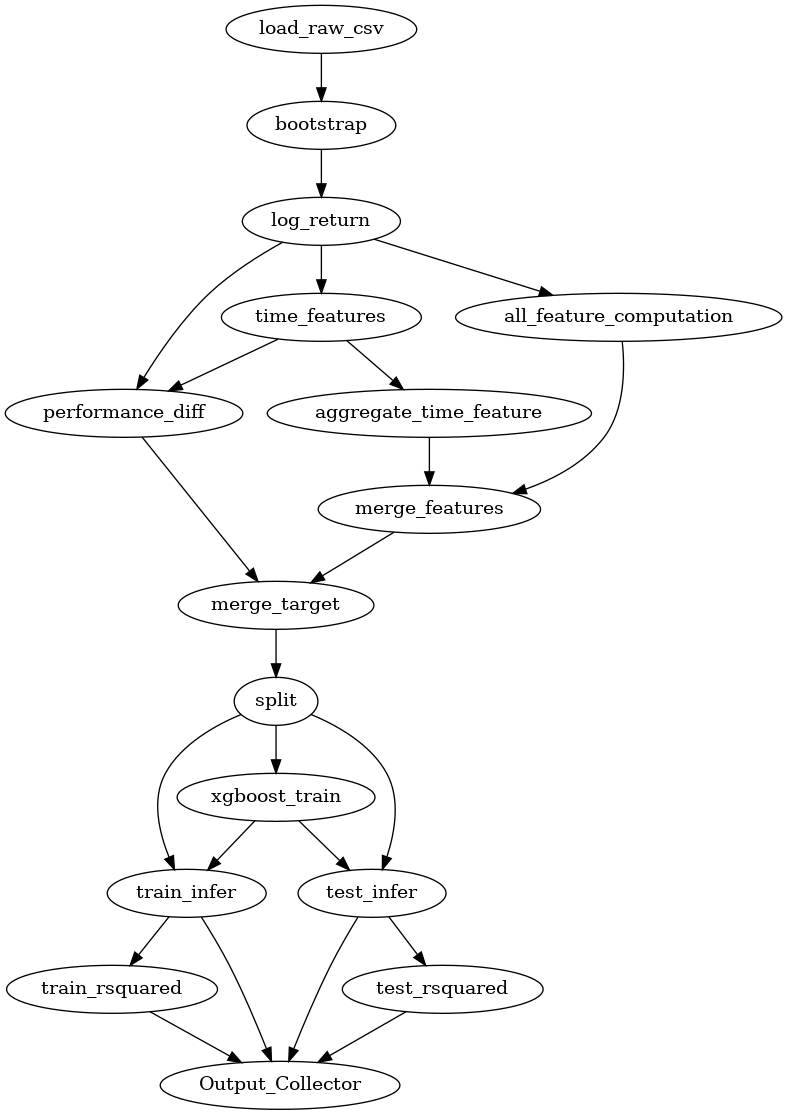

In [4]:
taskGraph.draw(show='ipynb')

Run and collect the results:

In [5]:
result = taskGraph.run()

start new Cluster


Let's check the R-squared score for both Train dataset and Test dataset

In [6]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.9996610473281385 Test R-Squared: 0.16453180924889146


Text(0.5, 1.0, 'Test')

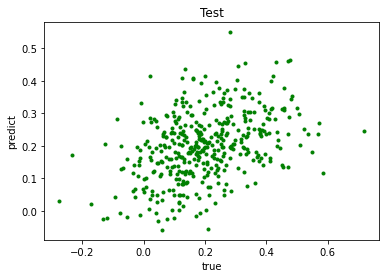

In [7]:
pl.plot(result['test_infer.out'].portfolio.values.get(), result['test_infer.out'].predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

Text(0.5, 1.0, 'Train')

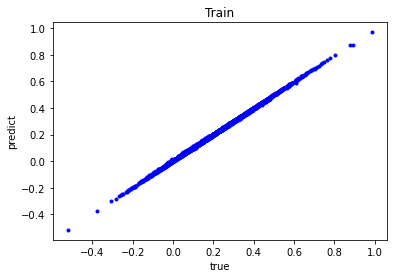

In [8]:
pl.plot(result['train_infer.out'].portfolio.values.get(), result['train_infer.out'].predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Clearly the XGBoost model is overfitted as we only use 4096 datapoints. We will use more datapoints later

## The explanation method

We will use Shapley values of feature contribution to explain the ML result. In simple words, what Shapley values tell us is how much each feature (the statistical properties ofthe asset universe described above) has contributed to a specific outcome of theML model. Because of the complexity (non-linearity) of the model, this is a non-trivial task. The Shapley value is a quantity introduced in co-operative game theory to provide the fair payout to a player (the features) with respect to its contribution to the common goal (ML prediction). The SHAP framework (Lundberg and Lee (2017)) provides a tool to evaluate this quantity even in a model agnostic way. It allows comparing these quantitative explanations among different models.

Shapley values can be computed from the XGboost inference node. Following is the workflow to visualize the feature contributions. 

In [9]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

In [1]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [2]:
taskGraph=TaskGraph.load_taskgraph('./17assets/xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

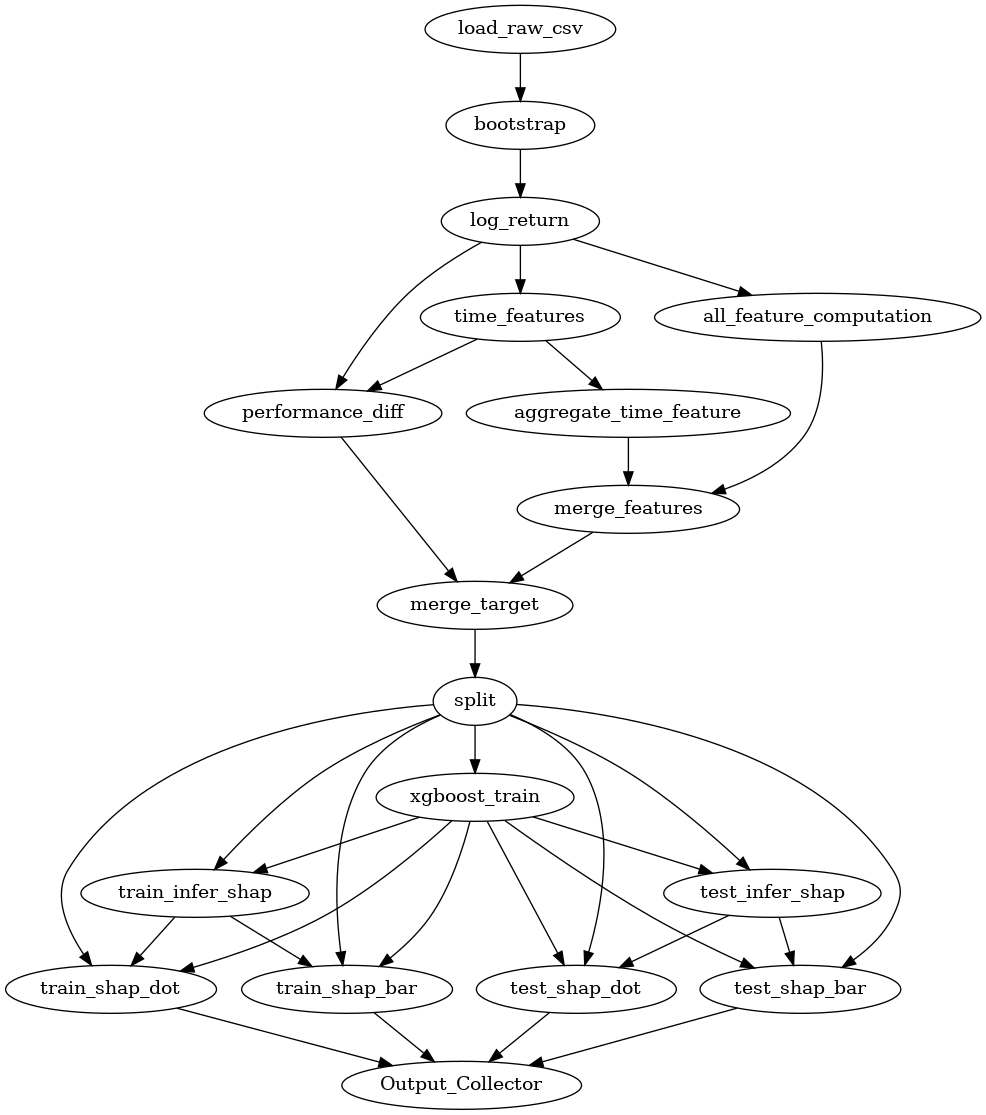

In [3]:
taskGraph.draw(show='ipynb')

start new Cluster


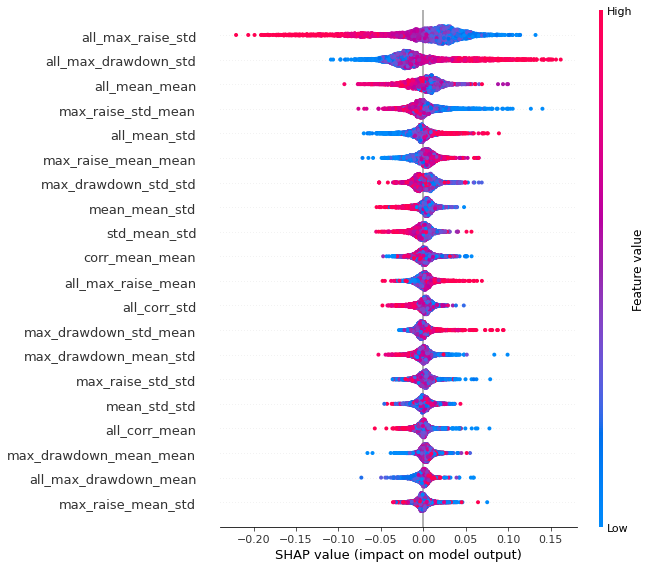

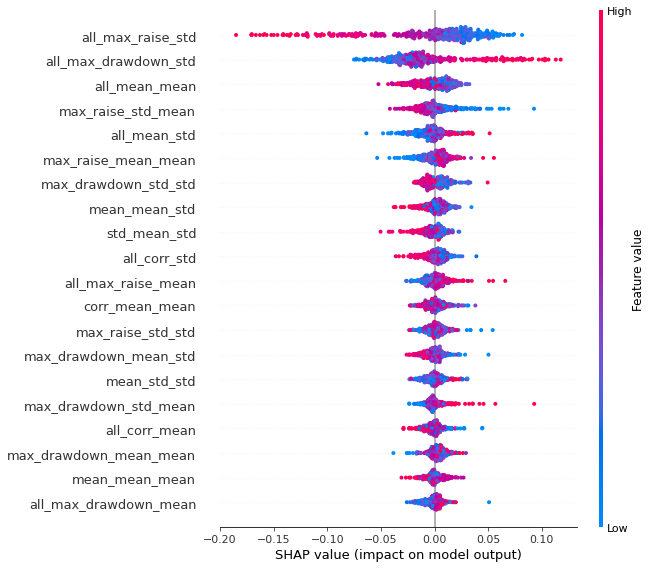

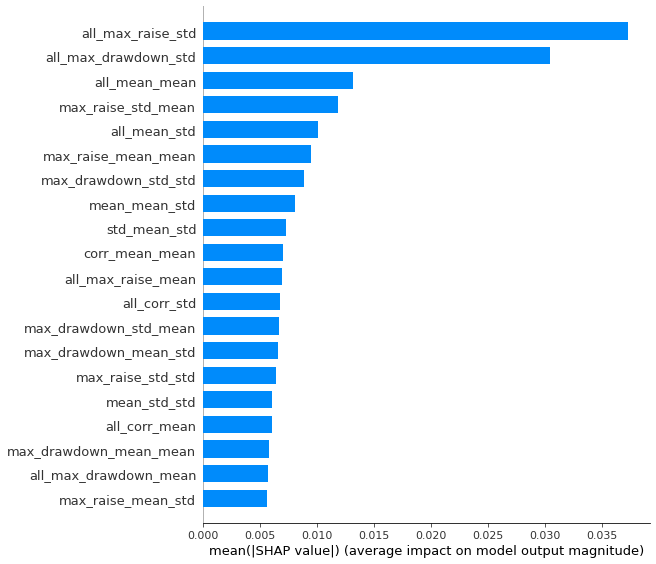

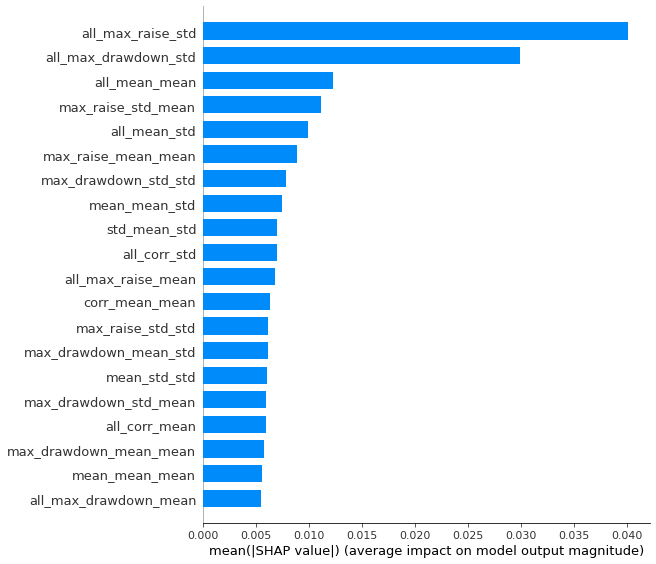

In [5]:
result = taskGraph.run()

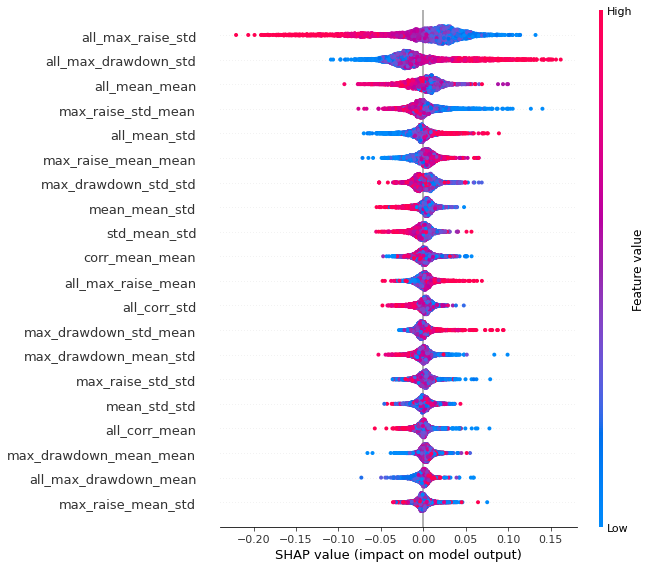

In [6]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

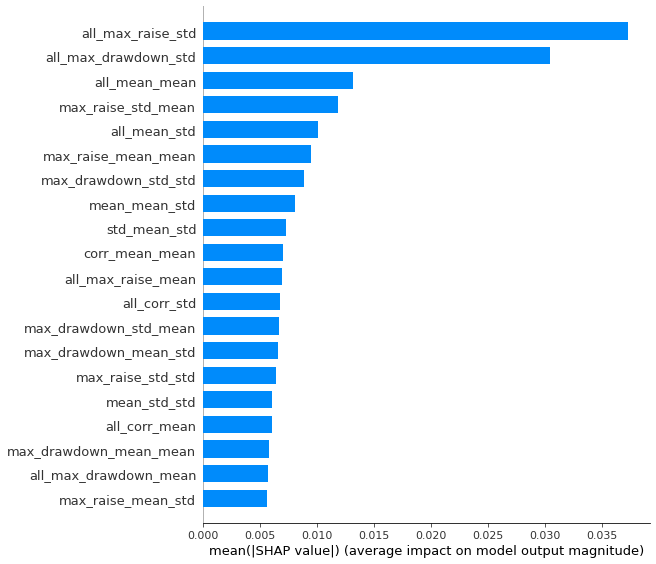

In [7]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

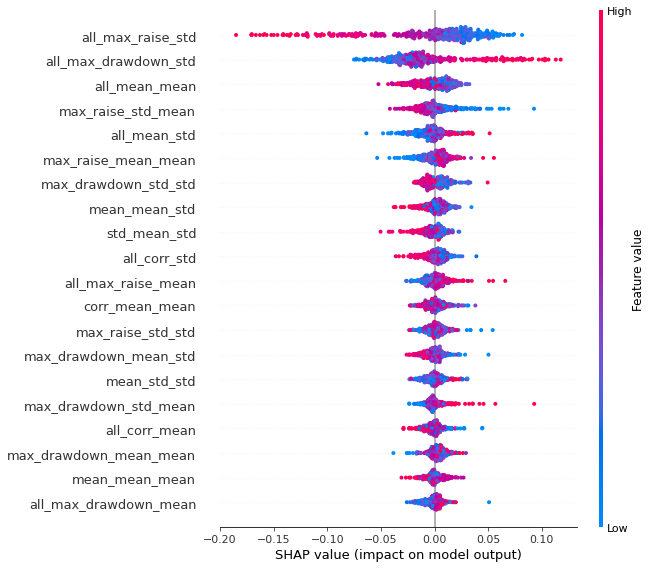

In [8]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

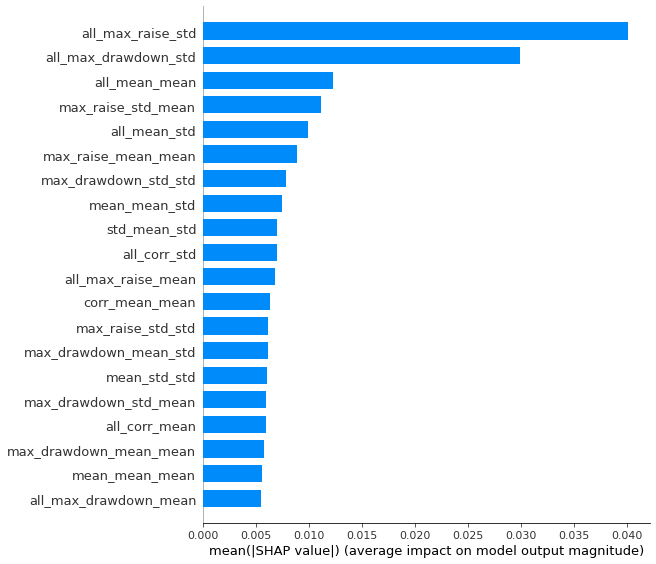

In [9]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

## Scale to 100K Samples

The maximum number of samples that can be computed in a single 32G V100 GPU is 4096. To compute 100K samples, we use Dask to distribute the workloads in multiple GPUs.


In [10]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

In [1]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [2]:
taskGraph=TaskGraph.load_taskgraph('./17assets/parallel_xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

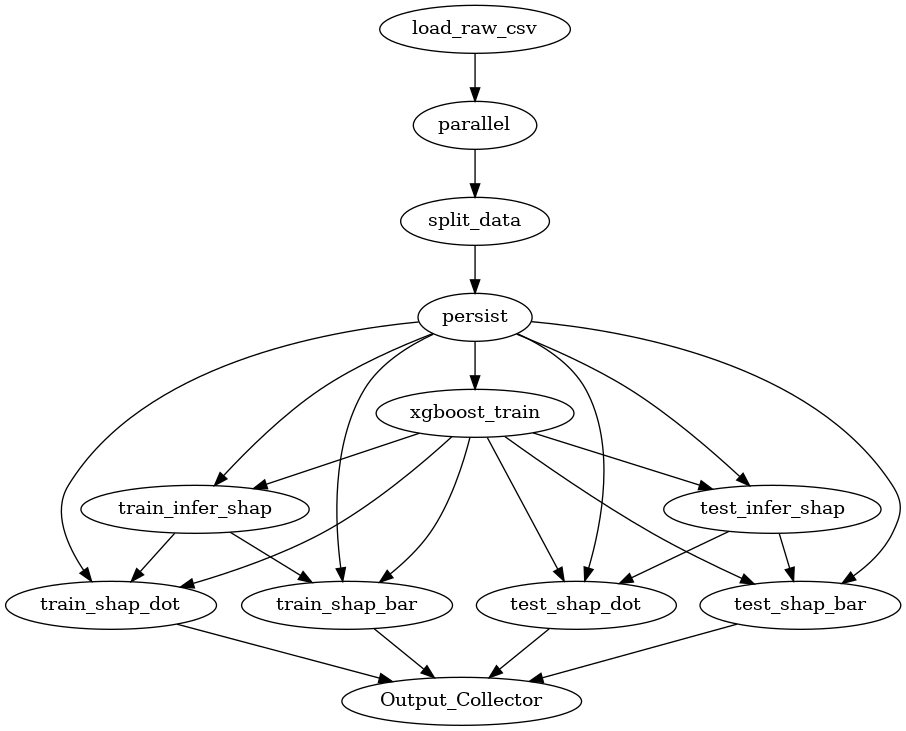

In [3]:
taskGraph.draw(show='ipynb')

start new Cluster


distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:45679
Traceback (most recent call last):
  File "/raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/site-packages/distributed/comm/core.py", line 320, in connect
    handshake = await asyncio.wait_for(comm.read(), time_left())
  File "/raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/asyncio/tasks.py", line 501, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/site-packages/distributed/worker.py", line 2189, in gather_dep
    response = await get_data_from_worker(
  File "/raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/site-packages/distributed/worker.py", line 3475, in get_data_from_worker
    return await retry_operation(_get_data, operation="get_data_from_worker")
  File "/r

CPU times: user 18.4 s, sys: 2.92 s, total: 21.3 s
Wall time: 3min 50s


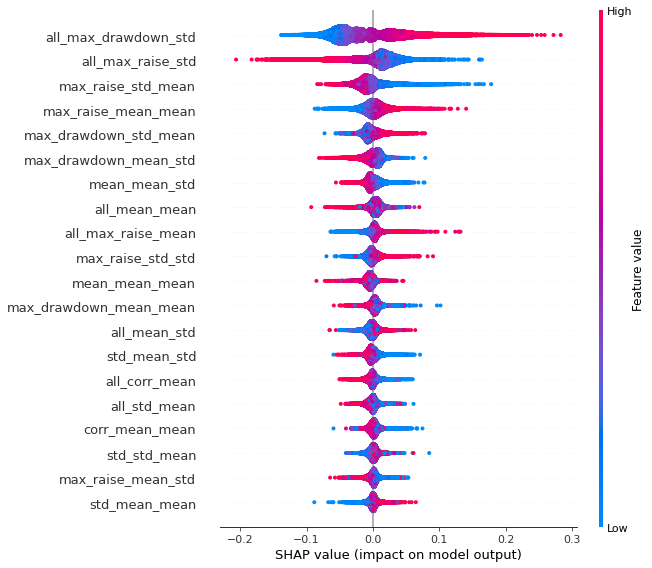

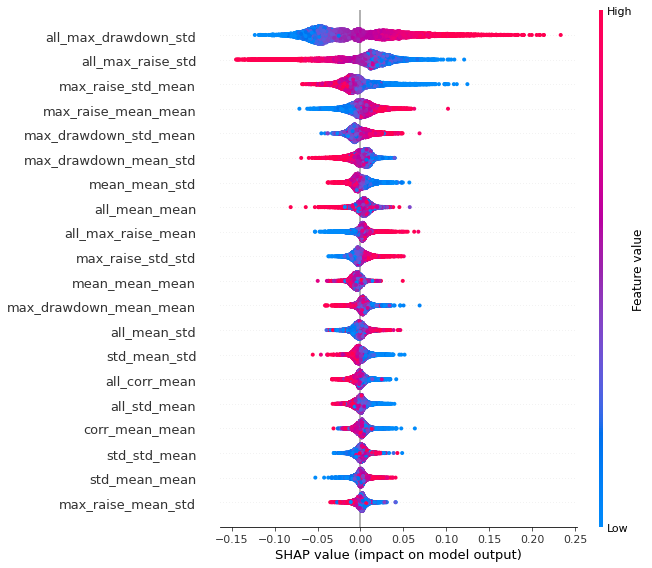

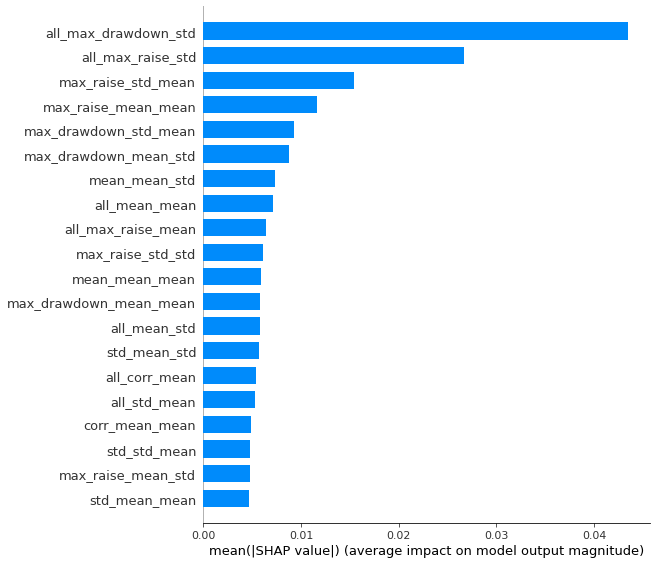

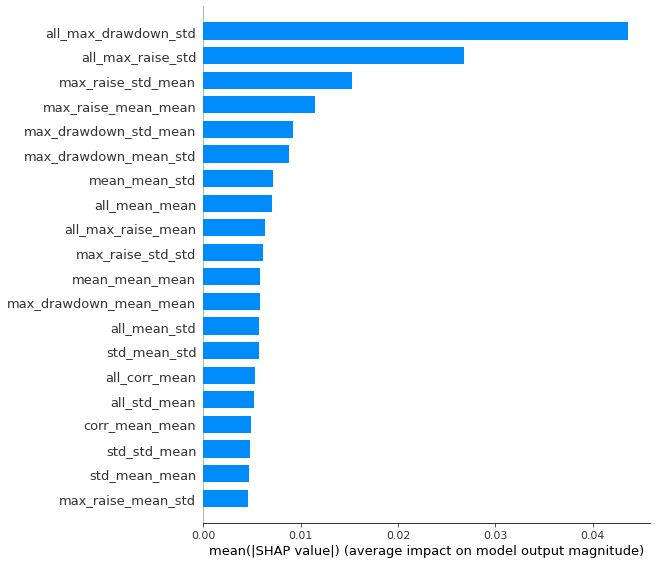

In [5]:
%time result = taskGraph.run()

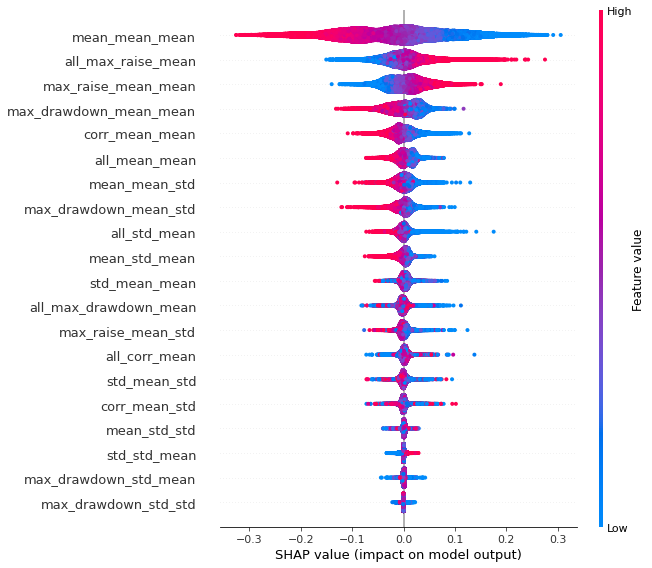

In [36]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

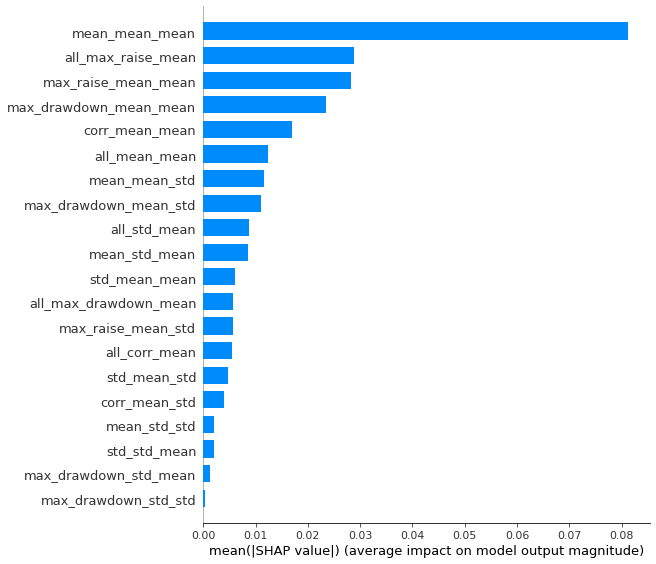

In [37]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

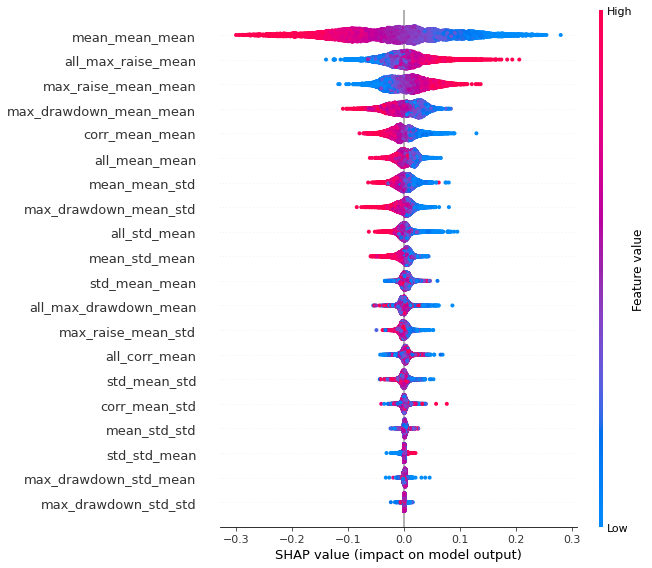

In [38]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

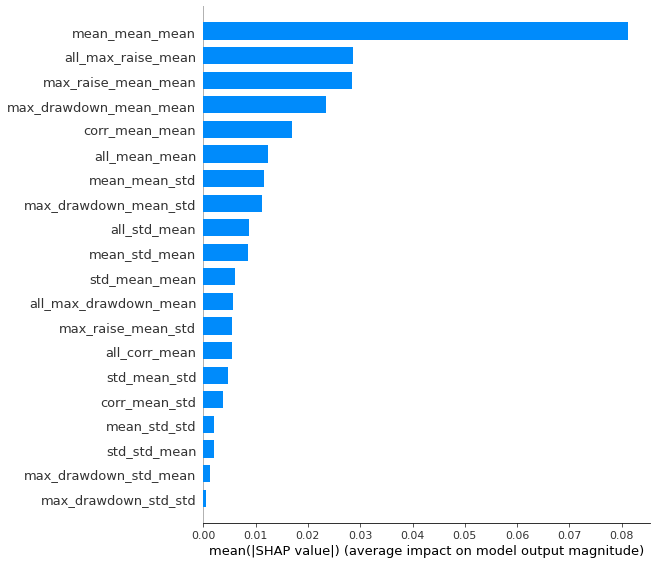

In [39]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

We run the XGboost performance metrics again for 100K samples:

In [20]:
taskGraph=TaskGraph.load_taskgraph('./17assets/parallel_xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

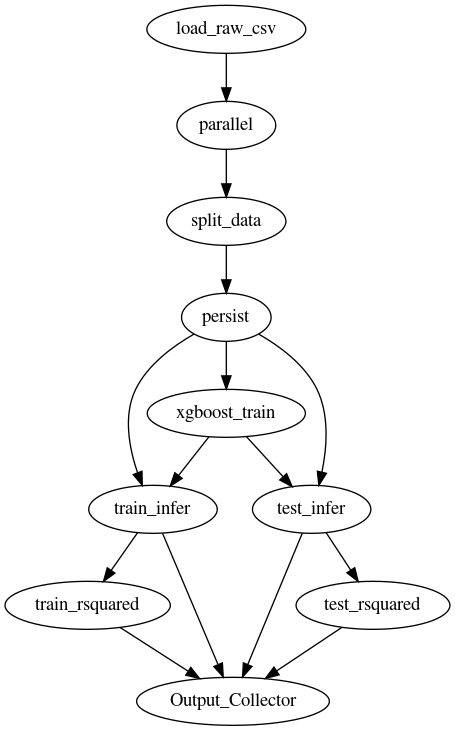

In [21]:
taskGraph.draw(show='ipynb')

In [4]:
%time result = taskGraph.run()

CPU times: user 17.7 s, sys: 2.07 s, total: 19.8 s
Wall time: 3min 44s


In [6]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.5569616818796833 Test R-Squared: 0.17076214976895115


In [7]:
train_infer_df = result['train_infer.out'].compute()
test_infer_df = result['test_infer.out'].compute()

Text(0.5, 1.0, 'Train')

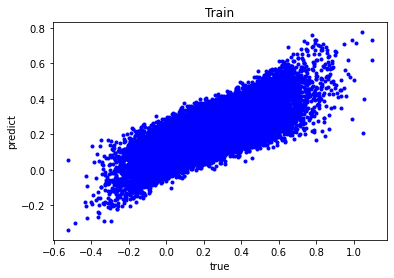

In [8]:
pl.plot(train_infer_df.portfolio.values.get(), train_infer_df.predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Text(0.5, 1.0, 'Test')

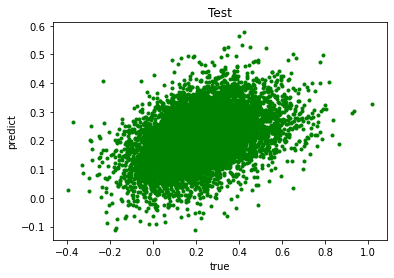

In [9]:
pl.plot(test_infer_df.portfolio.values.get(), test_infer_df.predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

## Hyperparameter Optimization

When data scientists are building machine learning models, there are a few magic numbers that are included in the model. The example numbers are depths in the tree, the learning rate, etc. The parameters that define the model architecture or training process are usually referred to as hyperparameters. They are magical because there is no good theory about what number to choose. Commonly, the hyperparameters can be searched to find a good set of them that results in the best model performance. The process of searching is referred to as hyperparameter tuning.

There are a few popular Python-based hyperparameter tuning libraries existing: Ray Tune, Optuna, HyperOpt. Each library provides a set of search algorithms and schedule algorithms that is easy to use.

Inside the `greenflow` project, we implemented a Context Composite Node that can flexibly expose the hyperparameters that are interesting for tuning. The Context Composite Node makes hyperparameter tuning easy to do by leveraging the hyperparameter tuning libraries. Inside `greenflow_gquant_plugin` project, there is a `GridRandomSearchNode` that can do random and grid search with Ray Tune library for the hyperparameters. First, we need to initialize the ray tune environment.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [ ]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

In [ ]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [2]:
import ray
ray.init()

2021-02-26 08:19:18,253	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.110.106.133',
 'raylet_ip_address': '10.110.106.133',
 'redis_address': '10.110.106.133:6379',
 'object_store_address': '/tmp/ray/session_2021-02-26_08-19-17_689880_18496/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-26_08-19-17_689880_18496/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-26_08-19-17_689880_18496',
 'metrics_export_port': 55033,
 'node_id': '147d24b5c9f2323ba56bf1103c24a06ac6a05026'}

Following is the workflow to run HPO. As a simple example, we will search the `num_rounds` and `eta` parameters in the XGBoost model. We use grid search for `num_rounds` and random search for `eta`. Click on the `GridRandomSearchNode`, you can see how we configure the search space.

In [23]:
taskGraph=TaskGraph.load_taskgraph('./17assets/hpo.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'xgboost_train'), ('type', 'ContextCompositeNode'), ('c…

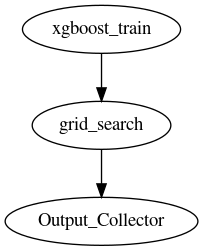

In [24]:
taskGraph.draw(show='ipynb')

In [6]:
taskGraph.run()

2021-02-26 08:22:10,642	WARNING experiment_analysis.py:132 -- Not able to retrieve the best config for ./ray/exp according to the specified metric (only nans encountered).
2021-02-26 08:22:10,688	WARNING experiment_analysis.py:132 -- Not able to retrieve the best config for ./ray/exp according to the specified metric (only nans encountered).
2021-02-26 08:22:10,703	WARNING experiment_analysis.py:132 -- Not able to retrieve the best config for ./ray/exp according to the specified metric (only nans encountered).


Trial name,status,loc,eta,num_rounds
search_fun_c71ce_00000,RUNNING,,0.151422,100


(pid=18649) start new Cluster


(pid=18649) [08:25:56] task [xgboost.dask]:tcp://127.0.0.1:35091 got new rank 0
(pid=18649) [08:25:56] task [xgboost.dask]:tcp://127.0.0.1:45425 got new rank 1
(pid=18649) [08:25:56] task [xgboost.dask]:tcp://127.0.0.1:33703 got new rank 2
(pid=18649) [08:25:56] task [xgboost.dask]:tcp://127.0.0.1:36951 got new rank 3


Result for search_fun_c71ce_00000:
  date: 2021-02-26_08-26-03
  done: false
  experiment_id: 8239795a55aa4ba8a062e4fb7c4e3839
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 18649
  test_rsquared.out: 0.19406217111464638
  time_since_restore: 230.04425168037415
  time_this_iter_s: 230.04425168037415
  time_total_s: 230.04425168037415
  timestamp: 1614356763
  timesteps_since_restore: 0
  train_rsquared.out: 0.4427530408213427
  training_iteration: 1
  trial_id: c71ce_00000
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_c71ce_00000,RUNNING,10.110.106.133:18649,0.151422,100,1,230.044,0.442753,0.194062
search_fun_c71ce_00001,PENDING,,0.207174,110,,,,


Result for search_fun_c71ce_00000:
  date: 2021-02-26_08-26-03
  done: true
  experiment_id: 8239795a55aa4ba8a062e4fb7c4e3839
  experiment_tag: 0_eta=0.15142,num_rounds=100
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 18649
  test_rsquared.out: 0.19406217111464638
  time_since_restore: 230.04425168037415
  time_this_iter_s: 230.04425168037415
  time_total_s: 230.04425168037415
  timestamp: 1614356763
  timesteps_since_restore: 0
  train_rsquared.out: 0.4427530408213427
  training_iteration: 1
  trial_id: c71ce_00000
  


(pid=18649) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18649) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18649) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18649) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18649) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18

(pid=18646) start new Cluster


(pid=18646) [08:29:53] task [xgboost.dask]:tcp://127.0.0.1:46821 got new rank 0
(pid=18646) [08:29:53] task [xgboost.dask]:tcp://127.0.0.1:34653 got new rank 1
(pid=18646) [08:29:53] task [xgboost.dask]:tcp://127.0.0.1:35279 got new rank 2
(pid=18646) [08:29:53] task [xgboost.dask]:tcp://127.0.0.1:33041 got new rank 3


Result for search_fun_c71ce_00001:
  date: 2021-02-26_08-30-00
  done: false
  experiment_id: d46692c9e74c4626a734b9b987835ea2
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 18646
  test_rsquared.out: 0.19742435009779924
  time_since_restore: 234.5724127292633
  time_this_iter_s: 234.5724127292633
  time_total_s: 234.5724127292633
  timestamp: 1614357000
  timesteps_since_restore: 0
  train_rsquared.out: 0.5158688685401414
  training_iteration: 1
  trial_id: c71ce_00001
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_c71ce_00001,RUNNING,10.110.106.133:18646,0.207174,110,1,234.572,0.515869,0.197424
search_fun_c71ce_00002,PENDING,,0.116592,120,,,,
search_fun_c71ce_00000,TERMINATED,,0.151422,100,1,230.044,0.442753,0.194062


Result for search_fun_c71ce_00001:
  date: 2021-02-26_08-30-00
  done: true
  experiment_id: d46692c9e74c4626a734b9b987835ea2
  experiment_tag: 1_eta=0.20717,num_rounds=110
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 18646
  test_rsquared.out: 0.19742435009779924
  time_since_restore: 234.5724127292633
  time_this_iter_s: 234.5724127292633
  time_total_s: 234.5724127292633
  timestamp: 1614357000
  timesteps_since_restore: 0
  train_rsquared.out: 0.5158688685401414
  training_iteration: 1
  trial_id: c71ce_00001
  


(pid=18646) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18646) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18646) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18646) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18646) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18

(pid=18647) start new Cluster


(pid=18647) [08:34:04] task [xgboost.dask]:tcp://127.0.0.1:39231 got new rank 0
(pid=18647) [08:34:04] task [xgboost.dask]:tcp://127.0.0.1:34267 got new rank 1
(pid=18647) [08:34:04] task [xgboost.dask]:tcp://127.0.0.1:44959 got new rank 2
(pid=18647) [08:34:04] task [xgboost.dask]:tcp://127.0.0.1:42881 got new rank 3


Result for search_fun_c71ce_00002:
  date: 2021-02-26_08-34-11
  done: false
  experiment_id: 4679ed5b360a4fd0ba88fea38a593fab
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 18647
  test_rsquared.out: 0.2055684561342577
  time_since_restore: 248.69842338562012
  time_this_iter_s: 248.69842338562012
  time_total_s: 248.69842338562012
  timestamp: 1614357251
  timesteps_since_restore: 0
  train_rsquared.out: 0.4418737980527908
  training_iteration: 1
  trial_id: c71ce_00002
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_c71ce_00002,RUNNING,10.110.106.133:18647,0.116592,120,1,248.698,0.441874,0.205568
search_fun_c71ce_00000,TERMINATED,,0.151422,100,1,230.044,0.442753,0.194062
search_fun_c71ce_00001,TERMINATED,,0.207174,110,1,234.572,0.515869,0.197424


Result for search_fun_c71ce_00002:
  date: 2021-02-26_08-34-11
  done: true
  experiment_id: 4679ed5b360a4fd0ba88fea38a593fab
  experiment_tag: 2_eta=0.11659,num_rounds=120
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 18647
  test_rsquared.out: 0.2055684561342577
  time_since_restore: 248.69842338562012
  time_this_iter_s: 248.69842338562012
  time_total_s: 248.69842338562012
  timestamp: 1614357251
  timesteps_since_restore: 0
  train_rsquared.out: 0.4418737980527908
  training_iteration: 1
  trial_id: c71ce_00002
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_c71ce_00000,TERMINATED,,0.151422,100,1,230.044,0.442753,0.194062
search_fun_c71ce_00001,TERMINATED,,0.207174,110,1,234.572,0.515869,0.197424
search_fun_c71ce_00002,TERMINATED,,0.116592,120,1,248.698,0.441874,0.205568


2021-02-26 08:34:11,755	INFO tune.py:448 -- Total run time: 720.94 seconds (720.92 seconds for the tuning loop).
(pid=18647) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18647) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18647) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18647) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=18647) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNod

start new Cluster
get best {'eta': 0.11659227783645121, 'num_rounds': 120}


Results([('grid_search.conf_out', <greenflow.plugin_nodes.util.data_obj.ConfData object at 0x7f62f03f5f40>), ('grid_search.test_rsquared@out', 0.20339725901752542)])

In above simple HPO run, we see more rounds in the XGBoost training help to increase the test R-squared score. HPO is a time consuming process, GPU make it possible as we reduce the time to run 100K bootstrap samples from days in CPU cluster to 4 mins in DGX station. Feel free to add more hyperparamerters and increase the number of trails in above workflow.

## Scale to 1 million Samples

As the last part of this notebook, let's scale the computation to 1 million bootstrap samples. Ideall, the computation should scale linearly. We use the same taskgraph but increase the number or iterations 10 fold.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [ ]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

In [ ]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [22]:
taskGraph=TaskGraph.load_taskgraph('./17assets/parallel_xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

CPU times: user 2min 41s, sys: 16.4 s, total: 2min 58s
Wall time: 31min 36s


Results([('train_shap_dot.summary_plot', <Figure size 576x684 with 2 Axes>), ('test_shap_dot.summary_plot', <Figure size 576x684 with 2 Axes>), ('train_shap_bar.summary_plot', <Figure size 576x684 with 1 Axes>), ('test_shap_bar.summary_plot', <Figure size 576x684 with 1 Axes>)])

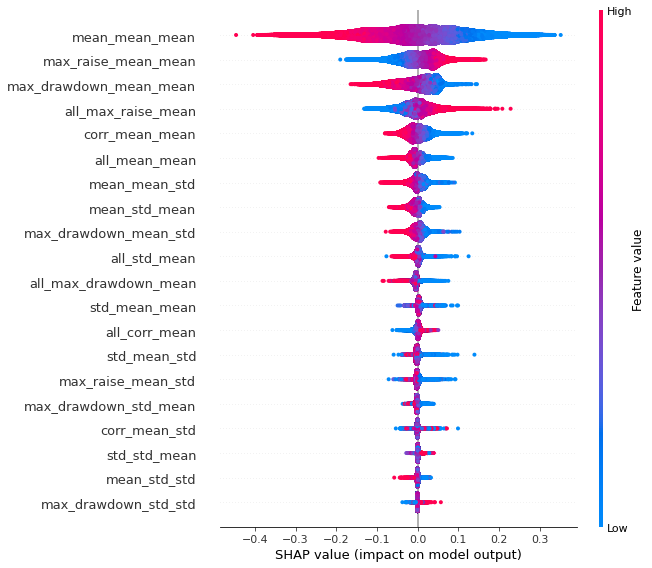

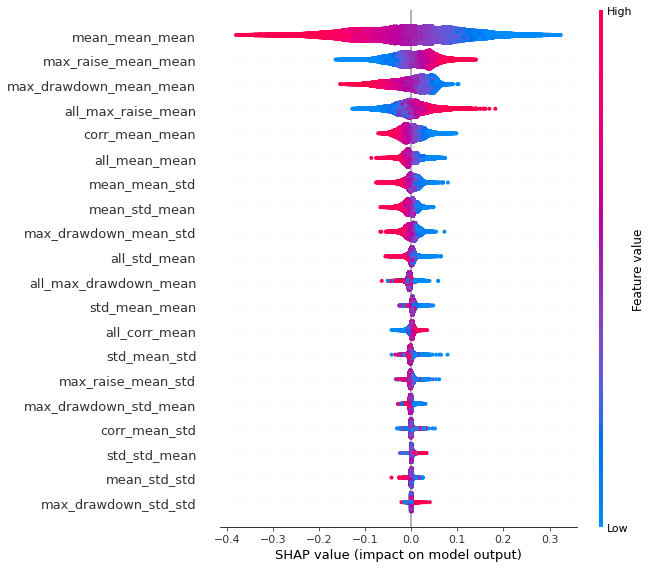

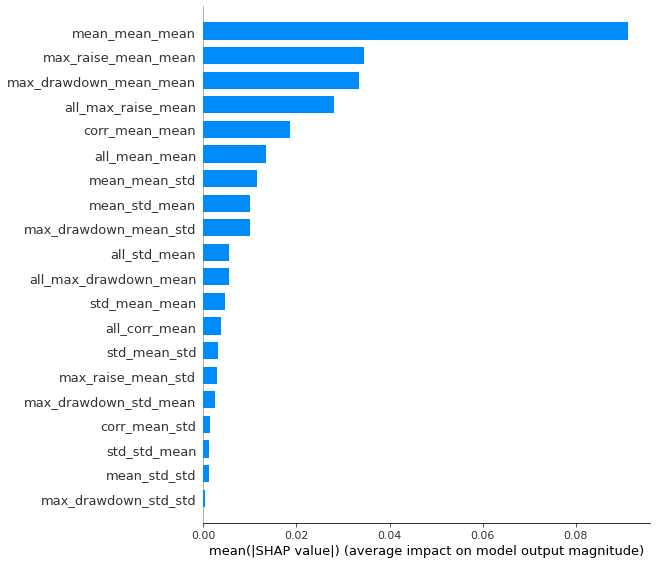

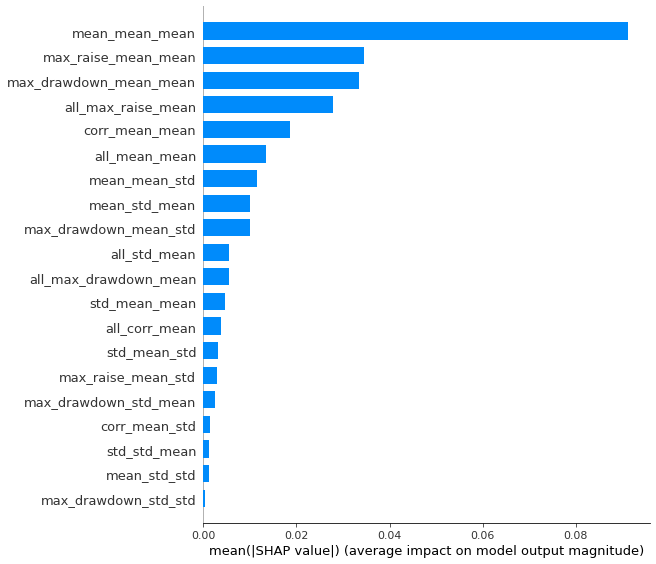

In [5]:
%%time
taskGraph.run(replace={
    "parallel" : {
        "conf": {
            "input": ["bootstrap.in"],
            "output": ["merge_target.merged"],
            "map": [{"node_id": "bootstrap",
                     "xpath": "bootstrap.conf.offset"
                    }],
            "taskgraph": "notebooks/17assets/full_workflow_xgboost_performance.gq.yaml",
            "iterations": 250
        }
    }
})